In [1]:
import sys
import os
import requests

import torch
from torch import nn

import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import torch.nn.functional as F


In [2]:
from torchvision.models import resnet34


model = resnet34(pretrained = True)



c:\Users\manki\OneDrive\Documents\knowledge distillation 2_new model\env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\manki\OneDrive\Documents\knowledge distillation 2_new model\env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
#to enable GPU
#if you don't have a GPU, comment out this part or use google colab when ready

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
#preproccessing 
#to resize image and other transformation to reduce overfitting 

data_transform = transforms.Compose([
    transforms.Resize(size=(112, 112)),
    transforms.RandomHorizontalFlip(p=0.7),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
]) 

In [5]:
#loads pre-split data sets
#labels are the folders that images are in

#for simplicity, for the first part where we split yes disease from no disease, 
#put diease classes in a single folder called "yes findings". Make sure not to include the folders that the diseases where in

#for part 2, rerun the preproc script to get the split datasets and delete the "no findings" folder in each

p1 = "vehicle data 4 model"
#p2 =  "Car Model 4 model"


train_data = datasets.ImageFolder(root= p1 + "/train",
                                  transform=data_transform, 
                                  target_transform=None) 

test_data = datasets.ImageFolder(root= p1 + "/test",
                                 transform=data_transform)


validation_data = datasets.ImageFolder(root= p1 + "/val",
                                 transform=data_transform)

train_data, test_data ,validation_data

(Dataset ImageFolder
     Number of datapoints: 2561
     Root location: vehicle data 4 model/train
     StandardTransform
 Transform: Compose(
                Resize(size=(112, 112), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.7)
                RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 728
     Root location: vehicle data 4 model/test
     StandardTransform
 Transform: Compose(
                Resize(size=(112, 112), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.7)
                RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 389
     Root location: vehicle data 4 model/val
     StandardTransform
 Transform: Compose(
             

Image: torch.Size([112, 112, 3]) 


Text(0.5, 1.0, 'helicopter')

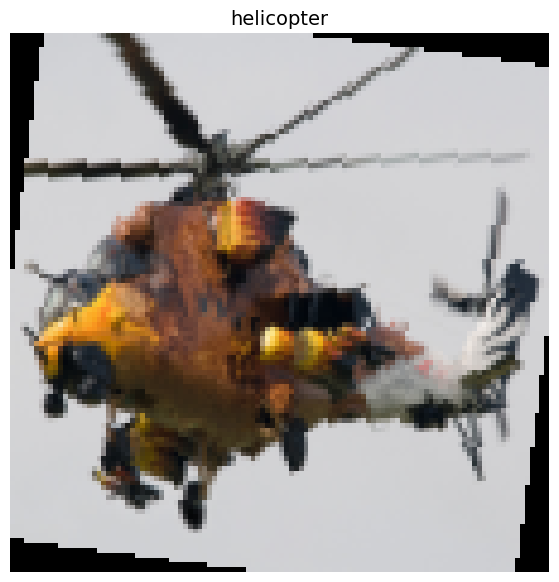

In [6]:
import random 
from PIL import Image
import matplotlib.pyplot as plt

#this part loads an image for visualization, 
#this is for check if transformation have been applied and images are loading properly

class_names = train_data.classes
class_dict = train_data.class_to_idx

randNum = torch.randint(0, len(train_data), size=(1,)).item()
img, label = train_data[randNum][0], train_data[randNum][1]


img_permute = img.permute(1, 2, 0) #change order of of dimensions to (height, width, channel)


print(f"Image: {img_permute.shape} ")

plt.figure(figsize=(12, 7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

In [7]:
BATCH_SIZE=64
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)


train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1abe466a4a0>,
 <torch.utils.data.dataloader.DataLoader at 0x1abe466a770>)

In [8]:
#modify fc layers for classification 
#len(class_names) is to have the code auto adjust the number of output in relation to our task

model.fc = nn.Sequential (
    nn.Linear(512,512),
    nn.Dropout(0.2),
     nn.Linear(512,256),
    nn.Linear(256,len(class_names)), # -> len(labels) labels according to labels
)
model.fc

Sequential(
  (0): Linear(in_features=512, out_features=512, bias=True)
  (1): Dropout(p=0.2, inplace=False)
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): Linear(in_features=256, out_features=20, bias=True)
)

In [9]:
from torch.optim import lr_scheduler
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

In [10]:
from torchinfo import summary
summary(model, input_size=[1, 3, 224, 224])

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 20]                   --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

In [11]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device=device):
  
    model.train()

    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device) #enter to GPU

        y_pred = model(X) 

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        # Calculate accuracy metric
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class==y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader) 
    
    return train_loss, train_acc 

In [12]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
    
    model.eval()

    test_loss, test_acc = 0,  0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader): 
            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [13]:
from tqdm.auto import tqdm

#tqdm makes loop show progress bar

def train(model: torch.nn.Module,
          train_dataloader,
          test_dataloader,
          optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5, 
          device=device):
  
    results = {"train_loss": [],
                "train_acc": [],
                "test_loss": [],
                "test_acc": []}
  
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                            dataloader=train_dataloader,
                                            loss_fn=loss_fn,
                                            optimizer=optimizer,
                                            device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)


        print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        

    return results

c:\Users\manki\OneDrive\Documents\knowledge distillation 2_new model\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []

epoch = 0


In [15]:
NUM_EPOCHS = 15


# Start the timer
from timeit import default_timer as timer
start_time = timer() 

model_0_results = train(model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

epoch += NUM_EPOCHS

  7%|▋         | 1/15 [01:40<23:27, 100.51s/it]

Epoch: 0 | Train loss: 2.9414 | Train acc: 0.0949 | Test loss: 2.8108 | Test acc: 0.2222


 13%|█▎        | 2/15 [03:20<21:39, 99.98s/it] 

Epoch: 1 | Train loss: 2.7448 | Train acc: 0.2546 | Test loss: 2.6159 | Test acc: 0.3672


 20%|██        | 3/15 [05:00<20:01, 100.10s/it]

Epoch: 2 | Train loss: 2.5195 | Train acc: 0.4062 | Test loss: 2.3900 | Test acc: 0.4327


 27%|██▋       | 4/15 [06:40<18:20, 100.08s/it]

Epoch: 3 | Train loss: 2.2745 | Train acc: 0.4973 | Test loss: 2.1735 | Test acc: 0.5113


 33%|███▎      | 5/15 [08:20<16:39, 99.96s/it] 

Epoch: 4 | Train loss: 2.0312 | Train acc: 0.5861 | Test loss: 1.9303 | Test acc: 0.5985


 40%|████      | 6/15 [10:00<14:59, 99.97s/it]

Epoch: 5 | Train loss: 1.8037 | Train acc: 0.6547 | Test loss: 1.7298 | Test acc: 0.6380


 47%|████▋     | 7/15 [11:39<13:18, 99.84s/it]

Epoch: 6 | Train loss: 1.5927 | Train acc: 0.6749 | Test loss: 1.5226 | Test acc: 0.6775


 53%|█████▎    | 8/15 [13:19<11:39, 99.97s/it]

Epoch: 7 | Train loss: 1.3934 | Train acc: 0.7058 | Test loss: 1.3786 | Test acc: 0.6918


 60%|██████    | 9/15 [14:59<09:59, 99.88s/it]

Epoch: 8 | Train loss: 1.2261 | Train acc: 0.7416 | Test loss: 1.2740 | Test acc: 0.6892


 67%|██████▋   | 10/15 [16:39<08:18, 99.78s/it]

Epoch: 9 | Train loss: 1.0983 | Train acc: 0.7580 | Test loss: 1.1518 | Test acc: 0.7057


 73%|███████▎  | 11/15 [18:19<06:39, 99.89s/it]

Epoch: 10 | Train loss: 0.9635 | Train acc: 0.7919 | Test loss: 1.0780 | Test acc: 0.7326


 80%|████████  | 12/15 [19:59<05:00, 100.07s/it]

Epoch: 11 | Train loss: 0.8666 | Train acc: 0.8102 | Test loss: 0.9744 | Test acc: 0.7400


 87%|████████▋ | 13/15 [21:39<03:19, 99.94s/it] 

Epoch: 12 | Train loss: 0.7658 | Train acc: 0.8270 | Test loss: 0.9673 | Test acc: 0.7352


 93%|█████████▎| 14/15 [23:19<01:39, 99.96s/it]

Epoch: 13 | Train loss: 0.6830 | Train acc: 0.8525 | Test loss: 0.8953 | Test acc: 0.7465


100%|██████████| 15/15 [24:59<00:00, 99.96s/it]

Epoch: 14 | Train loss: 0.6181 | Train acc: 0.8552 | Test loss: 0.8646 | Test acc: 0.7639
Total training time: 1499.338 seconds


In [16]:
train_loss.append(model_0_results['train_loss'])
test_loss.append(model_0_results['test_loss']) 
train_acc.append(model_0_results['train_acc'])
test_acc.append(model_0_results['test_acc']) 

In [17]:
#save model so you don't have to retrain
#additionally, change name so we have 2 save models
#one for part 1 another for part 2

import pickle

torch.save(model.state_dict(), "vehicle_type_model.pth")

with open("Vehicle type loss and acc.pkl", "wb") as file:
    pickle.dump(train_loss, file)
    pickle.dump(test_loss, file)
    pickle.dump(train_acc, file)
    pickle.dump(test_acc, file)
    pickle.dump(epoch, file)



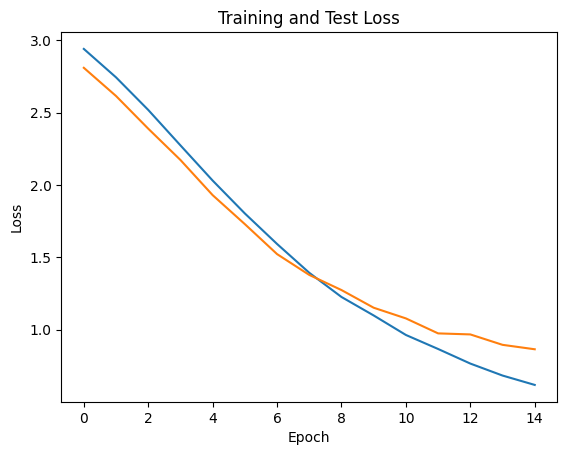

In [18]:
train_loss = model_0_results['train_loss'] 
test_loss = model_0_results['test_loss'] 

plt.plot(train_loss)
plt.plot(test_loss)
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()



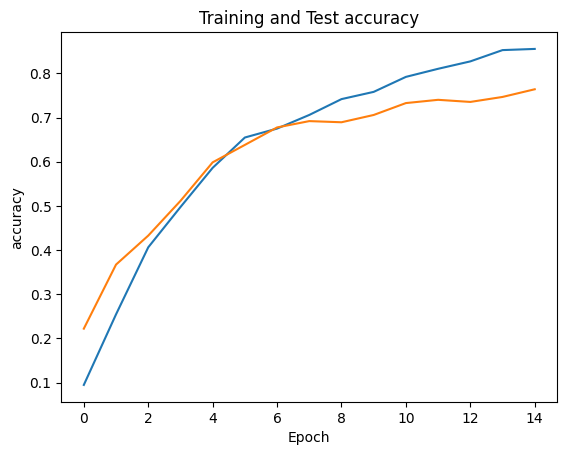

In [19]:
train_acc = model_0_results['train_acc'] 
test_acc = model_0_results['test_acc'] 

plt.plot(train_acc)
plt.plot(test_acc)
plt.title('Training and Test accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.show()

In [20]:
val_dataloader = DataLoader(dataset=validation_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

In [21]:
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import seaborn as sns

#this part runs the model with the validation set
#this is to get predictions with the validation set
#and get outputs for the confusion matrix

all_preds = []
all_labels = []

with torch.no_grad():
    for data in val_dataloader:
        inputs, labels = data

        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())




In [22]:
#test_pred_labels = test_pred_logits.argmax(dim=1)
#test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

matches = [1 if a == b else 0 for a,b in zip(all_preds, all_labels)]

numberOfCorrect = sum(matches)

acc = numberOfCorrect/len(all_labels)

print('Accuracy: {}'.format(acc))


Accuracy: 0.7634961439588689


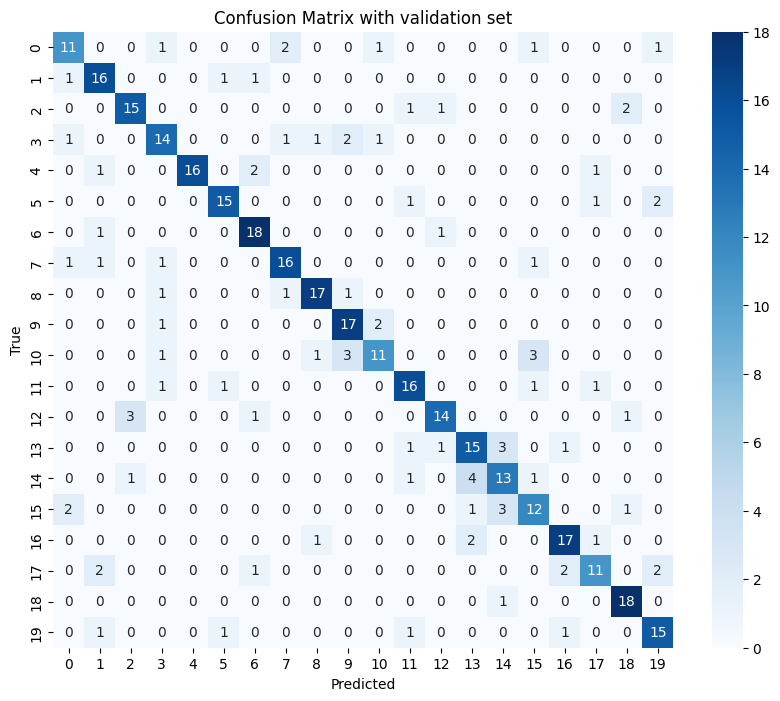

In [23]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix with validation set')
plt.show()
